## Import necessary modules


In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os, sys
os.chdir('drive/My Drive/Neural/SSM/Neural Analysis')

Mounted at /content/drive


In [2]:
# if not os.path.isdir('./ssm'):
#  !git clone https://github.com/lindermanlab/ssm.git
  # !cd ssm
  # !pip install numpy cython
  # !pip install -e ssm/.

In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

sys.path.append('/content/drive/My Drive/Neural/SSM/Neural Analysis/ssm')
#sys.path.append('ssm')
import ssm

import numpy as np
import numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
import os, datetime, yaml
from scipy import io as sio
from ssm.util import one_hot, find_permutation
import seaborn as sns
sns.set(palette="colorblind")

sns.set_style("white")
sns.set_context("talk")
sns.set_style('ticks',{"xtick.major.size":8,
"ytick.major.size":8})
from ssm.plots import gradient_cmap, white_to_color_cmap

color_names = [
    "purple",
    "red",
    "amber",
    "faded green",
    "windows blue",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load or Generate Data 

In [6]:
mat = sio.loadmat('./chewie_CO_CS_BL_10212016_001_py_5ms')

In [7]:
LATENCY = 5
assert LATENCY in [5,25]
mult = 2.5 if LATENCY == 25 else 0.5
mat = sio.loadmat(f'./chewie_CO_CS_BL_10212016_001_py_{LATENCY}ms')

num_cells = {'pmd':mat['neural_data_PMd'][0,0].shape[0], 
             'm1': mat['neural_data_M1'][0,0].shape[0],
             'all': mat['neural_data_PMd'][0,0].shape[0] +  mat['neural_data_M1'][0,0].shape[0]}

num_trials = mat['neural_data_PMd'].shape[1]

kin=mat['kinematics']
go_time_rel = mat['go_time_rel']
move_time_rel = mat['move_time_rel']

## find when cue is on to align all trials
kin_dt = 0.01
cue_on_bin= [int(mat['go_time_rel'][0,i][0,0]/kin_dt/mult) for i in range(mat['go_time_rel'].shape[1])]
move_bin= [int(mat['move_time_rel'][0,i][0,0]/kin_dt/mult) for i in range(mat['move_time_rel'].shape[1])]

ys = {'pmd':[], 'm1':[], 'all':[]}
for trial in range(num_trials):
  ys['all'].append(np.concatenate([mat['neural_data_PMd'][0,trial].T,mat['neural_data_M1'][0,trial].T], axis = 1).astype(int))
  ys['pmd'].append((mat['neural_data_PMd'][0,trial].T).astype(int))
  ys['m1'].append((mat['neural_data_M1'][0,trial].T).astype(int))

(array([13., 33., 41., 30., 33., 38., 38., 31., 23.,  6.]),
 array([313. , 337.5, 362. , 386.5, 411. , 435.5, 460. , 484.5, 509. ,
        533.5, 558. ]),
 <a list of 10 Patch objects>)

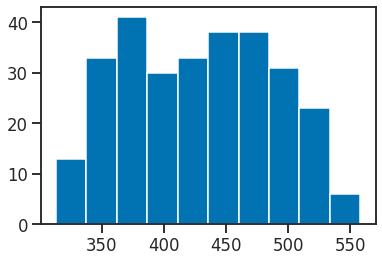

In [8]:
# TODO: What should I do here? 
plt.hist([y.shape[0] for y in ys['all']])

In [9]:
# num_steps = max([y.shape[0] for y in ys['all']])
# ys_padded = {'all' :np.array([np.pad(ys['all'][i],((0,num_steps - ys['all'][i].shape[0]),(0,0),), constant_values = 0) for i in range(num_trials)]),
#              'm1': np.array([np.pad(ys['m1'][i],((0,num_steps - ys['m1'][i].shape[0]),(0,0),), constant_values = 0) for i in range(num_trials)]),
#              'pmd': np.array([np.pad(ys['pmd'][i],((0,num_steps - ys['pmd'][i].shape[0]),(0,0),), constant_values = 0) for i in range(num_trials)])}

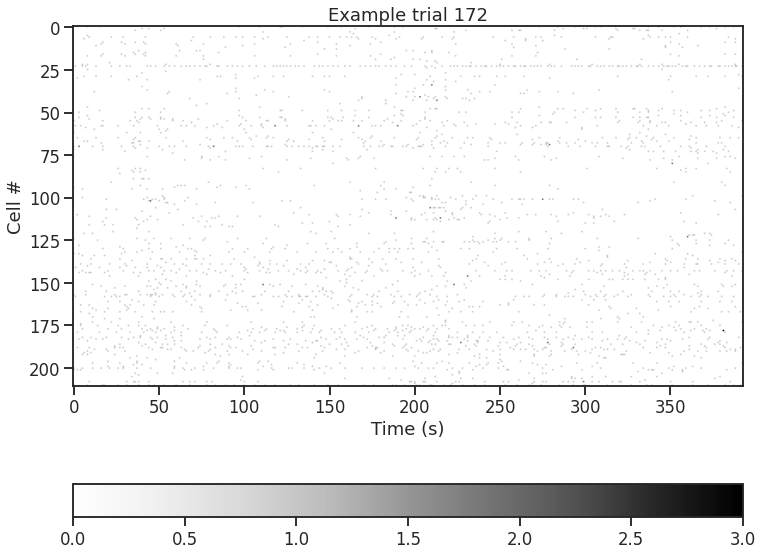

In [10]:
plt.figure(figsize = (12,12))
random_trial = np.random.randint(num_trials)
plt.imshow(ys['pmd'][random_trial].T, cmap=plt.cm.Greys)
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal')
plt.title(f'Example trial {random_trial}');

## SLDS

#### Test SLDS Gaussian

Initializing with an ARHMM using 25 steps of EM.


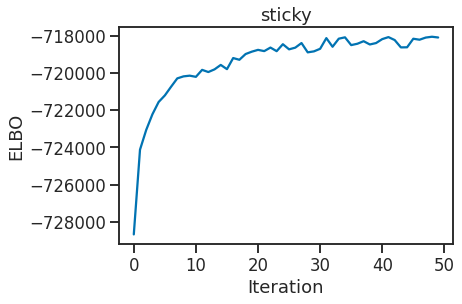

In [ ]:
DATASET = 'pmd'
for K in [4]:
  for D_latent in [6]:
    for transitions in ['sticky']:#, 'standard', 'sticky']:
      ### SLDS on spike 
      random_seed = 0
      np.random.seed(random_seed)

      #K = 3
      #D_latent = 5
      #transitions = 'sticky'
      D_obs = num_cells[DATASET] 
      dynamics="diagonal_gaussian"
      emissions="poisson"
      method="laplace_em"
      variational_posterior="structured_meanfield"
      
      initialize=10
      num_iters=50

      num_trials = 100
      rslds_full = ssm.SLDS(D_obs, K, D_latent,
                      transitions=transitions,
                      dynamics=dynamics,
                      emissions=emissions,
                      single_subspace=True)

      q_elbos_lem, q_lem = rslds_full.fit(ys[DATASET][:num_trials], method=method,
                                      variational_posterior=variational_posterior,
                                      initialize=initialize, num_iters=num_iters, alpha=0.0)

      plt.plot(q_elbos_lem[1:])
      plt.xlabel("Iteration")
      plt.ylabel("ELBO")
      plt.title(transitions)
      plt.show()

      zhat_lem = [rslds_full.most_likely_states(q_lem.mean_continuous_states[i], ys[DATASET][i]) for i in range(num_trials)]

      results = {'num_trials': num_trials, 'K': K, 'D_obs': D_obs, 'D_latent': D_latent, 
                                  'transitions': transitions,
                                  'dynamics': dynamics, 
                                  'emissions': emissions, 
                                  'method': method, 
                                  'variational_posterior': variational_posterior,
                                  'initialize': initialize, 'num_iters':num_iters,
                                  'zhat': zhat_lem, 'q_lem': q_lem, 'q_elbos_lem': q_elbos_lem, 
                                  'params':rslds_full.params,
                                  'random_seed': random_seed}

      np.save('SLDS_' + DATASET+ '_' + 'K=' + str(K) + '_D=' + str(D_latent) + '_Transitions=' + transitions + '_' + datetime.datetime.now().strftime('%y%m%d%H%M') +'.npy',np.array(results))

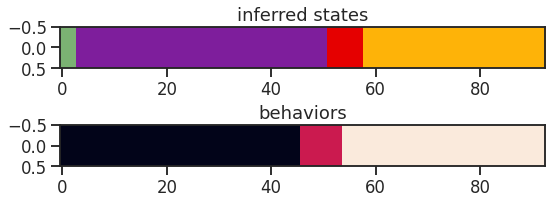

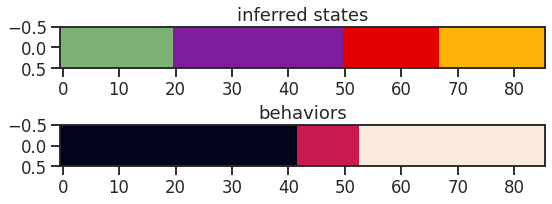

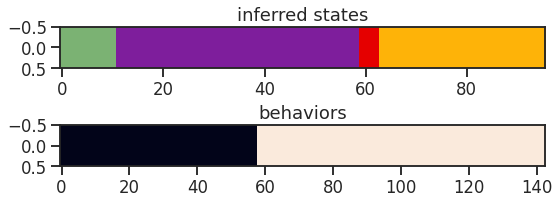

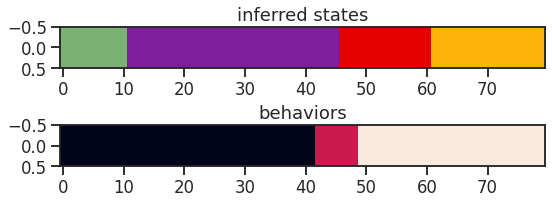

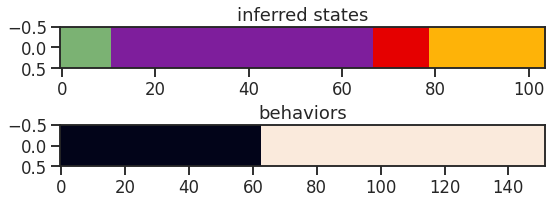

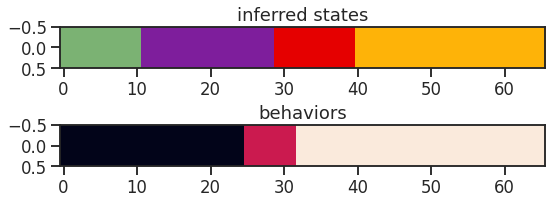

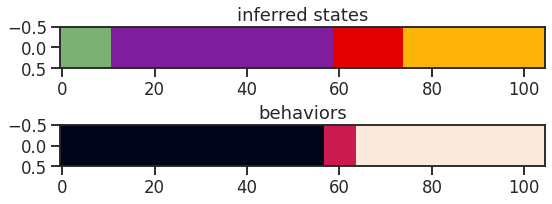

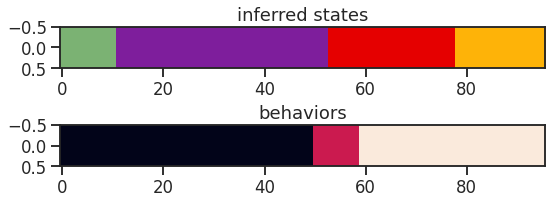

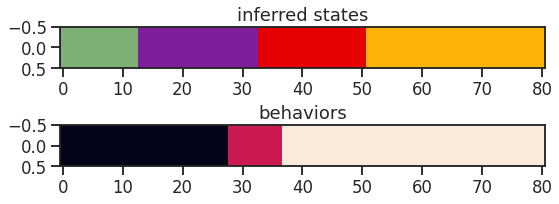

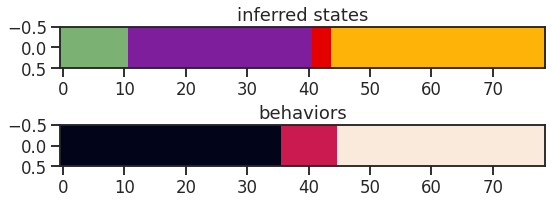

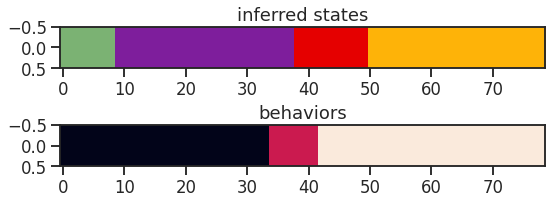

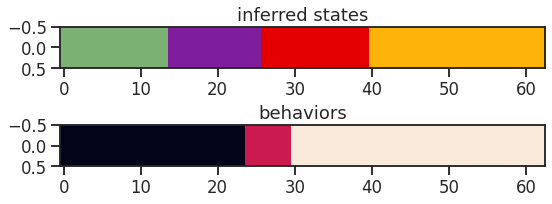

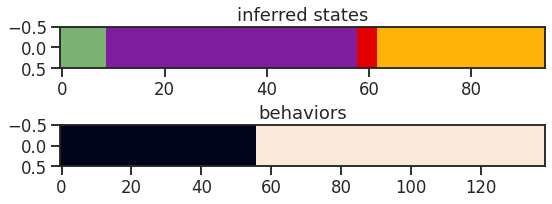

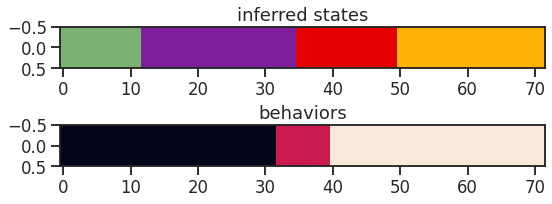

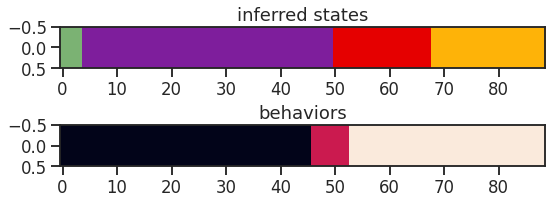

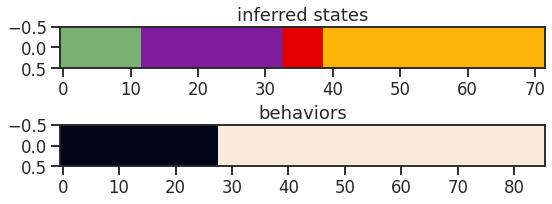

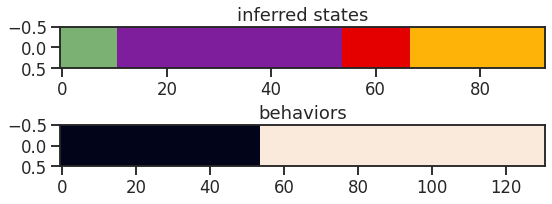

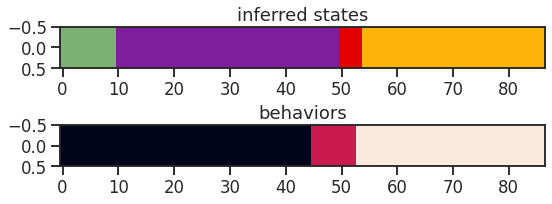

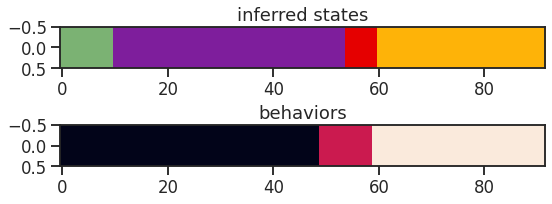

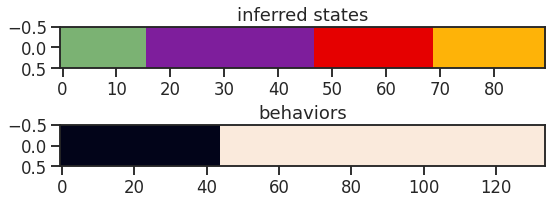

In [ ]:
for i in range(20):
  f, axarr = plt.subplots(2,1, figsize = (8,3))
  f.tight_layout()
  #f.set_figheight = 1
  #f.set_figwidth = 16
  #plt.figure(figsize = (8,1))
  axarr[0].imshow(zhat_lem[i][None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[0].set_title('inferred states')
  axarr[1].imshow([[1]*cue_on_bin[i] + [2] * (move_bin[i]-cue_on_bin[i]) + [3]*(len(zhat_lem[i]) - move_bin[i])] , aspect="auto")#, cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[1].set_title('behaviors')
  #plt.title(transitions + str(i))
  plt.show()

In [ ]:
temp= axarr[0]
temp.set_title('test')

Text(0.5, 1.0, 'test')

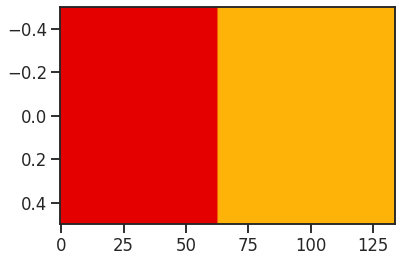

In [ ]:
zhat_lem[i][None,:]

array([[2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
[cue_on_bin[i],move_bin[i]]

[63, 71]

In [ ]:
# temp = q_lem.continuous_expectations

In [ ]:
# slds_xs = q_lem.mean
# rates = [rslds_full.smooth(x, y) for x, y in zip(slds_xs, ys[DATASET])]

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


AttributeError: ignored

In [ ]:
# # how to read output??
# output = [x for x in os.listdir() if 'SLDS_Full_pmd' in x]
# time = [int(x.strip('.npy').split('_')[-1]) for x in output]
# latest_file = output[ time.index(max(time))]
# read = np.load(latest_file, allow_pickle = True).tolist()

# for i in range(3):
#   plt.figure(figsize = (8,1))
#   plt.title(transitions + str(i))
#   plt.imshow(read['zhat'][i][None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
#   plt.show()


ValueError: ignored

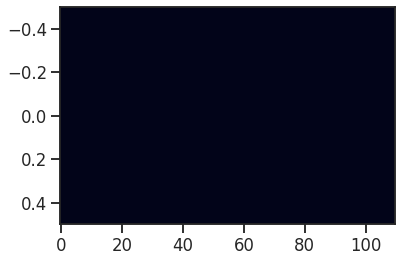

In [ ]:
# plt.imshow(zhat_lem[8][None,:], aspect="auto")#, cmap=cmap, vmin=0, vmax=len(colors)-1)


### Test SLDS on denoised rates

Initializing with an ARHMM using 25 steps of EM.


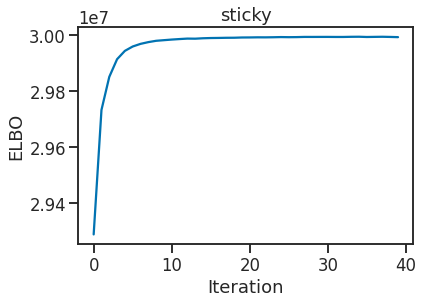

In [ ]:
### Single population
for K in [5]:
  for D_latent in [5]:
    for transitions in ['sticky']:
      random_seed = 0 
      np.random.seed(random_seed)

      #K = 3
      D_obs = num_cells[DATASET] 
      #D_latent = 5
      dynamics="gaussian"
      emissions="gaussian"
      method="laplace_em"
      variational_posterior="structured_meanfield"
      #transitions = 'sticky'

      initialize=5
      num_iters=40

      num_trials = 496
      rslds = ssm.SLDS(D_obs, K, D_latent,
                      transitions=transitions,
                      dynamics=dynamics,
                      emissions=emissions,
                      single_subspace=True)

      q_elbos_lem, q_lem = rslds.fit(xs[:num_trials], method=method,
                                      variational_posterior=variational_posterior,
                                      initialize=initialize, num_iters=num_iters, alpha=0.0)

      plt.plot(q_elbos_lem[1:])
      plt.xlabel("Iteration")
      plt.ylabel("ELBO")
      plt.title(transitions)
      plt.show()

      zhat_lem = [rslds.most_likely_states(q_lem.mean_continuous_states[i], xs[i]) for i in range(num_trials)]

      results = {'num_trials': num_trials, 'K': K, 'D_obs': D_obs, 'D_latent': D_latent, 
                                  'transitions': transitions,
                                  'dynamics': dynamics, 
                                  'emissions': emissions, 
                                  'method': method, 
                                  'variational_posterior': variational_posterior,
                                  'initialize': initialize, 'num_iters':num_iters,
                                  'zhat': zhat_lem, 'q_lem': q_lem, 'q_elbos_lem': q_elbos_lem, 
                                  'params':rslds.params,
                                  'random_seed': random_seed}

      np.save('SLDS_master_' + DATASET+ '_' + 'K=' + str(K) + '_D=' + str(D_latent) + '_Transitions=' + transitions + '_' + datetime.datetime.now().strftime('%y%m%d%H%M') +'.npy',np.array(results))

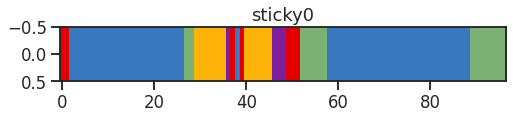

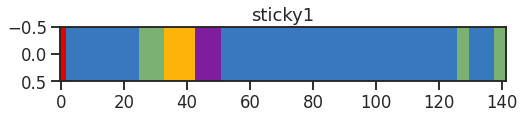

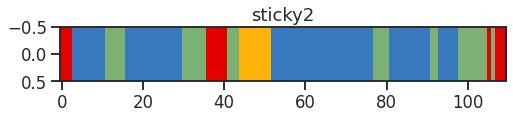

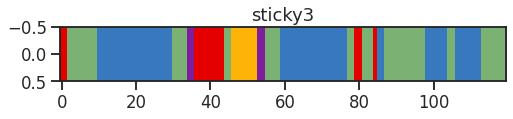

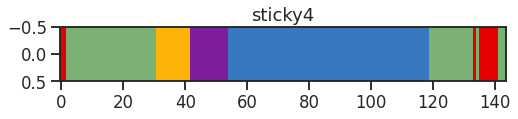

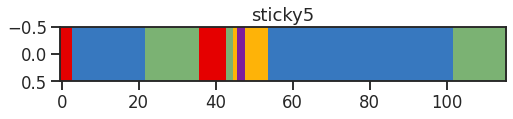

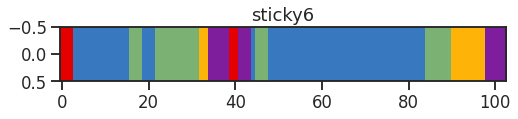

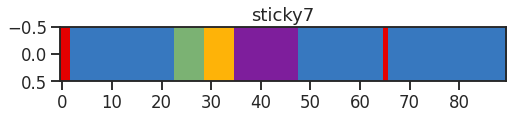

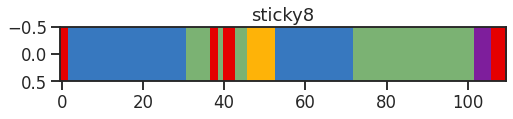

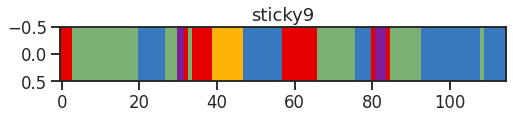

In [ ]:
for i in range(10):
  plt.figure(figsize = (8,1))
  plt.title(transitions + str(i))
  plt.imshow(zhat_lem[i][None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
  plt.show()
  # #plt.xlim(0, T)
  # plt.subplots(2,1)
  # plt.subplot(2,1,1)
  # plt.ylabel("$z_{\\mathrm{inferred}}$")
  # plt.yticks([])
  # plt.xlabel("time")
  # plt.tight_layout()
  # plt.title(transitions + str(i))
  # plt.subplot(2,1,2)
  # plt.imshow(xs_truncated[i].T)
  

### Test ARHM on factors

In [20]:
factors = np.load('./output/lfads/master_run_5ms_m1/factors_m1_padded.npy', allow_pickle = True)
inputs = np.load('./output/lfads/master_run_5ms_m1/inputs_m1_padded.npy', allow_pickle = True)

In [21]:
num_steps = factors[0].shape[0]
mock_inputs = [np.array([0]*(cue_on_bin[trial]-1) + [1] * 5 + [0] * (num_steps - cue_on_bin[trial]-4)).reshape(-1,1) for trial in range(num_trials)]
mock_inputs2 = [np.array([0]*(cue_on_bin[trial]-1) + [1] * (num_steps - cue_on_bin[trial]+1)).reshape(-1,1) for trial in range(num_trials)]

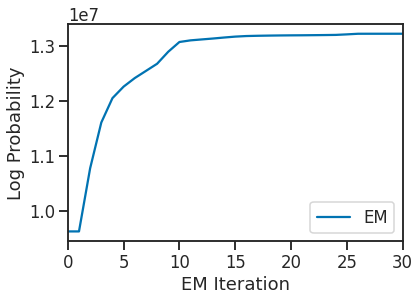

In [22]:
import pdb
TAG = 'rerun_with_autoregressive_mockinput2'
D_latent = 20
N_iters = 30
for K in range(4,5):
  for transitions in ['standard']:#, 'sticky', 'recurrent']:
    for withinput in [True]:#,False]:
      random_seed = 0
      np.random.seed(random_seed)

      if withinput:
        arhmm = ssm.HMM(K=K, D=20, M = 1,
                      transitions=transitions,
                      observations='autoregressive')

        hmm_lps = arhmm.fit(list(factors), inputs = mock_inputs2, method="em", num_iters=N_iters) #
        np.save(f'models/arhmm/m1/ARHMM_K={K}_iters={N_iters}_transitions={transitions}_m1_withinput_{TAG}', {'model': arhmm, 'training': hmm_lps})
      else:
        arhmm = ssm.HMM(K=K, D=20, 
                      transitions=transitions,
                      observations='autoregressive')

        hmm_lps = arhmm.fit(list(factors), method="em", num_iters=N_iters) #
        np.save(f'models/arhmm/m1/ARHMM_K={K}_iters={N_iters}_transitions={transitions}_m1_withoutinput_{TAG}', {'model': arhmm, 'training': hmm_lps})

      # Plot the log probabilities of the true and fit models
      plt.plot(hmm_lps, label="EM")
      plt.legend(loc="lower right")
      plt.xlabel("EM Iteration")
      plt.xlim(0, N_iters)
      plt.ylabel("Log Probability")
      plt.show()

In [ ]:
N_iters = 30
K = 4
TAG = 'rerun_with_autoregressive_mockinput'
transitions = 'standard'#, 'sticky', 'standard']:
withinput = np.load(f'models/arhmm/m1/ARHMM_K={K}_iters={N_iters}_transitions={transitions}_m1_withinput_{TAG}.npy', allow_pickle = True).tolist()
withoutinput = np.load(f'models/arhmm/m1/ARHMM_K={K}_iters={N_iters}_transitions={transitions}_m1_withoutinput_{TAG}.npy', allow_pickle = True).tolist()
for i in range(10):
  inferred_states_withinput = withinput['model'].most_likely_states(factors[i])
  inferred_states_withoutinput = withoutinput['model'].most_likely_states(factors[i])
  f, axarr = plt.subplots(3,1, figsize = (8,4))
  f.tight_layout()
  if move_bin[i] >= cue_on_bin[i]:
    axarr[0].imshow([[1]*cue_on_bin[i] + [2] * (move_bin[i]-cue_on_bin[i]) + [3]*(len(inferred_states_withinput) - move_bin[i])] , aspect="auto")#, cmap=cmap, vmin=0, vmax=len(colors)-1)
  else:
    axarr[0].imshow([[1]*cue_on_bin[i] + [3]*(len(inferred_states) - cue_on_bin[i])] , aspect="auto")#, cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[0].set_title('behaviors')
  axarr[1].imshow(inferred_states_withinput[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[1].set_title('inferred states with input')
  
  axarr[2].imshow(inferred_states_withoutinput[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[2].set_title('inferred states without input')
  plt.show()

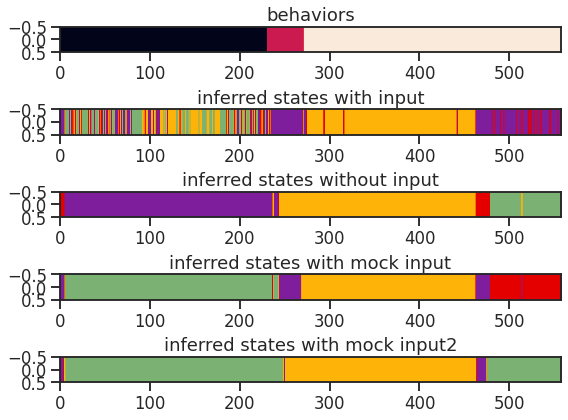

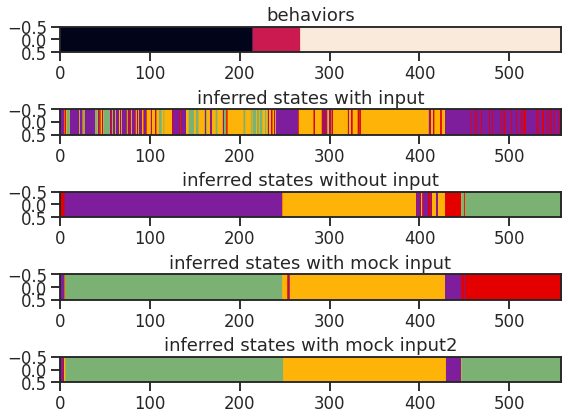

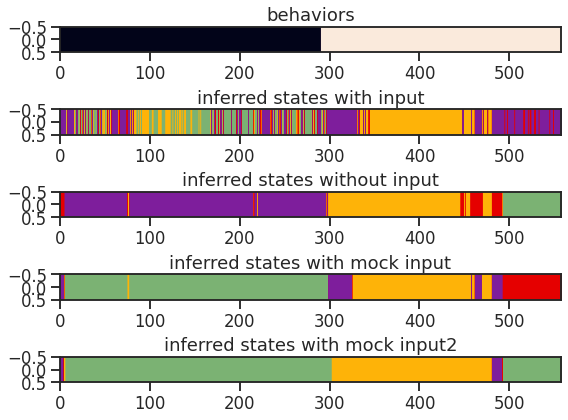

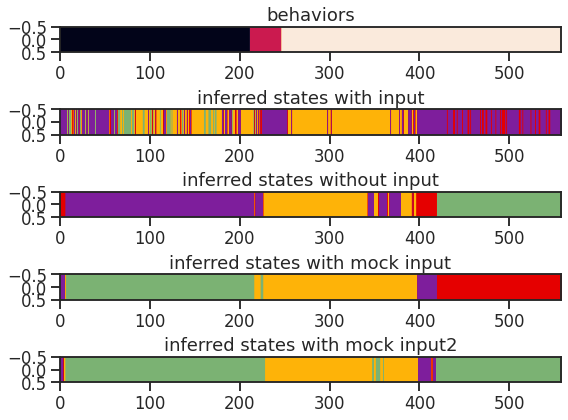

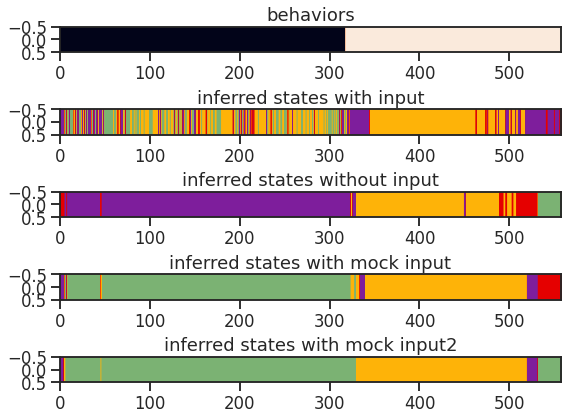

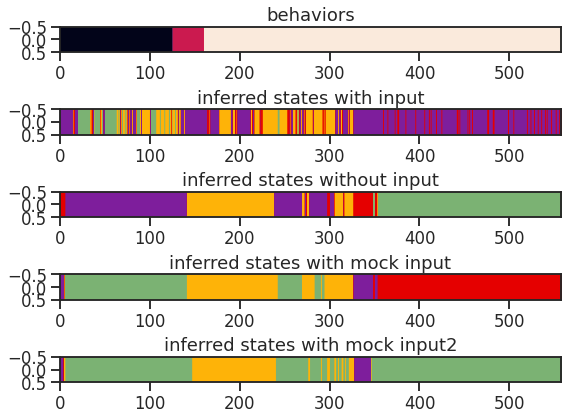

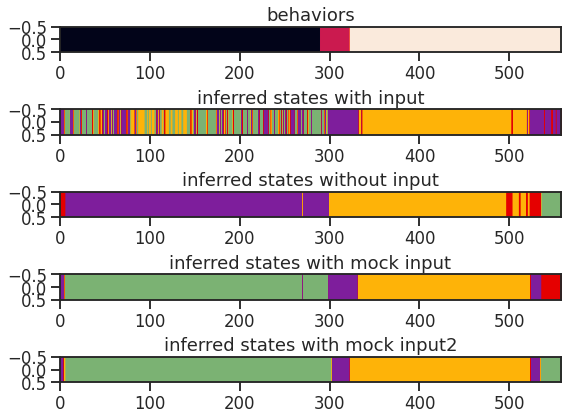

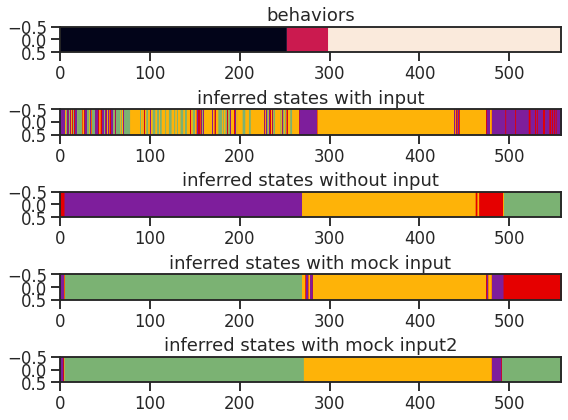

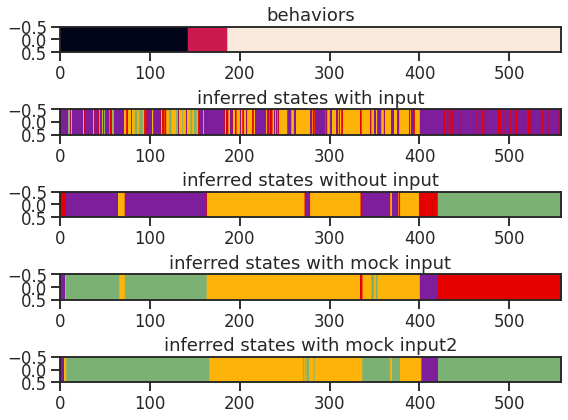

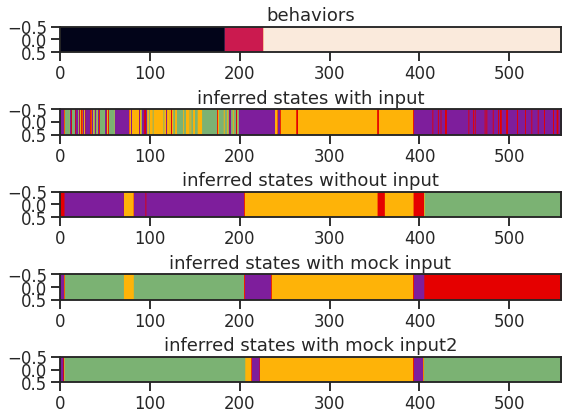

In [24]:
N_iters = 30
K = 4
transitions = 'standard'#, 'sticky', 'standard']:
withinput = np.load(f'models/arhmm/m1/ARHMM_K={K}_iters={N_iters}_transitions={transitions}_m1_withinput_rerun_with_autoregressive.npy', allow_pickle = True).tolist()
withoutinput = np.load(f'models/arhmm/m1/ARHMM_K={K}_iters={N_iters}_transitions={transitions}_m1_withoutinput_rerun_with_autoregressive.npy', allow_pickle = True).tolist()
withinputmock = np.load(f'models/arhmm/m1/ARHMM_K={K}_iters={N_iters}_transitions={transitions}_m1_withinput_rerun_with_autoregressive_mockinput.npy', allow_pickle = True).tolist()
withinputmock2 = np.load(f'models/arhmm/m1/ARHMM_K={K}_iters={N_iters}_transitions={transitions}_m1_withinput_rerun_with_autoregressive_mockinput2.npy', allow_pickle = True).tolist()
for i in range(10):
  inferred_states_withinput = withinput['model'].most_likely_states(factors[i])
  inferred_states_withoutinput = withoutinput['model'].most_likely_states(factors[i])
  inferred_states_withinputmock = withinputmock['model'].most_likely_states(factors[i])
  inferred_states_withinputmock2 = withinputmock2['model'].most_likely_states(factors[i])
  f, axarr = plt.subplots(5,1, figsize = (8,6))
  f.tight_layout()
  if move_bin[i] >= cue_on_bin[i]:
    axarr[0].imshow([[1]*cue_on_bin[i] + [2] * (move_bin[i]-cue_on_bin[i]) + [3]*(len(inferred_states_withinput) - move_bin[i])] , aspect="auto")#, cmap=cmap, vmin=0, vmax=len(colors)-1)
  else:
    axarr[0].imshow([[1]*cue_on_bin[i] + [3]*(len(inferred_states_withinput) - cue_on_bin[i])] , aspect="auto")#, cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[0].set_title('behaviors')
  axarr[1].imshow(inferred_states_withinput[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[1].set_title('inferred states with input')
  
  axarr[2].imshow(inferred_states_withoutinput[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[2].set_title('inferred states without input')

  axarr[3].imshow(inferred_states_withinputmock[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[3].set_title('inferred states with mock input')

  axarr[4].imshow(inferred_states_withinputmock2[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[4].set_title('inferred states with mock input2')
  plt.show()

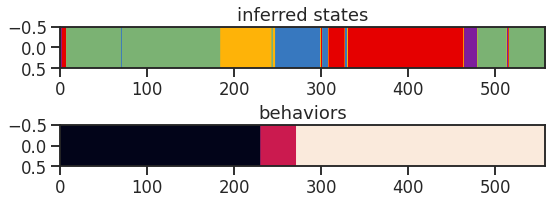

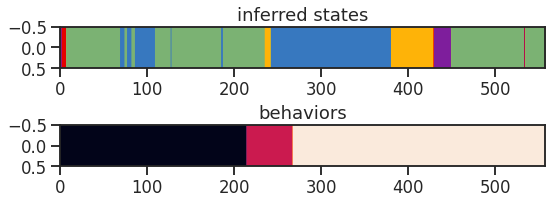

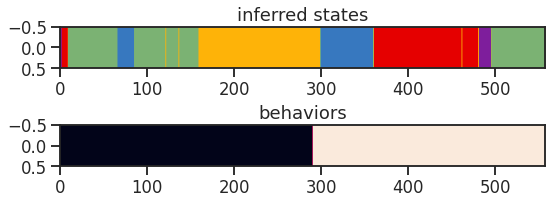

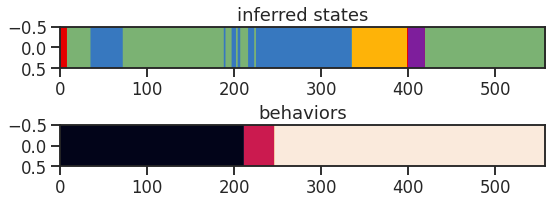

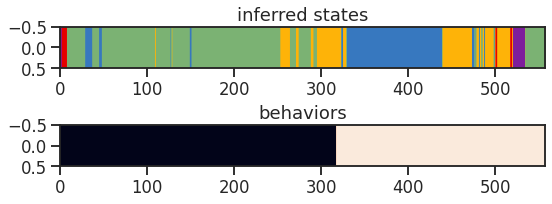

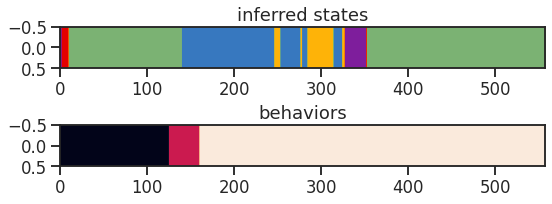

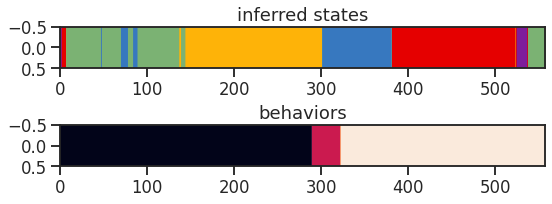

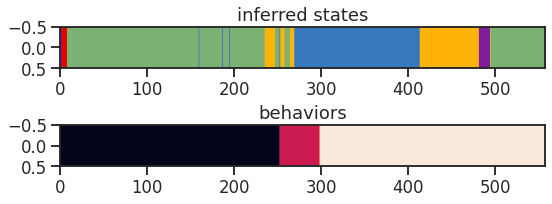

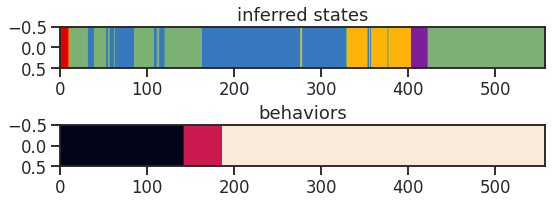

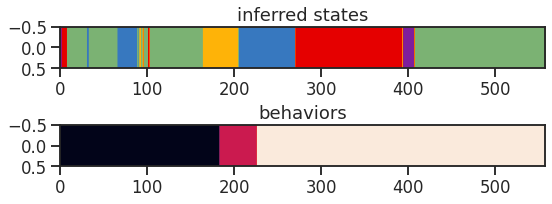

In [ ]:
N_iters = 30
K = 5
transitions = 'standard'#, 'sticky', 'standard']:
test = np.load(f'models/arhmm/m1/ARHMM_K={K}_iters={N_iters}_transitions={transitions}_m1_rerun_withoutinput.npy', allow_pickle = True).tolist()
for i in range(10):
  inferred_states = test['model'].most_likely_states(factors[i])
  f, axarr = plt.subplots(2,1, figsize = (8,3))
  f.tight_layout()
  axarr[0].imshow(inferred_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[0].set_title('inferred states')
  if move_bin[i] >= cue_on_bin[i]:
    axarr[1].imshow([[1]*cue_on_bin[i] + [2] * (move_bin[i]-cue_on_bin[i]) + [3]*(len(inferred_states) - move_bin[i])] , aspect="auto")#, cmap=cmap, vmin=0, vmax=len(colors)-1)
  else:
    axarr[1].imshow([[1]*cue_on_bin[i] + [3]*(len(inferred_states) - cue_on_bin[i])] , aspect="auto")#, cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[1].set_title('behaviors')
  plt.show()

In [ ]:
for i in range(3):
  inferred_states = test['model'].most_likely_states(factors[i])
  f, axarr = plt.subplots(2,1, figsize = (8,3))
  f.tight_layout()
  axarr[0].imshow(inferred_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[0].set_title('inferred states')
  if move_bin[i] >= cue_on_bin[i]:
    axarr[1].imshow([[1]*cue_on_bin[i] + [2] * (move_bin[i]-cue_on_bin[i]) + [3]*(len(inferred_states) - move_bin[i])] , aspect="auto")#, cmap=cmap, vmin=0, vmax=len(colors)-1)
  else:
    axarr[1].imshow([[1]*cue_on_bin[i] + [3]*(len(inferred_states) - cue_on_bin[i])] , aspect="auto")#, cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[1].set_title('behaviors')
  plt.show()

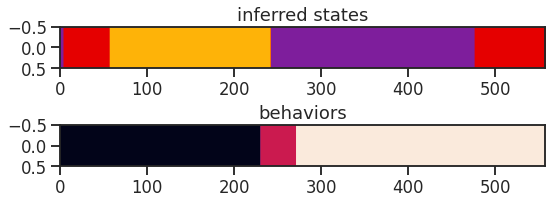

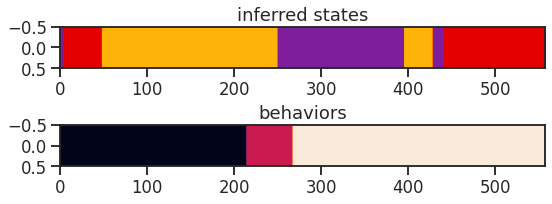

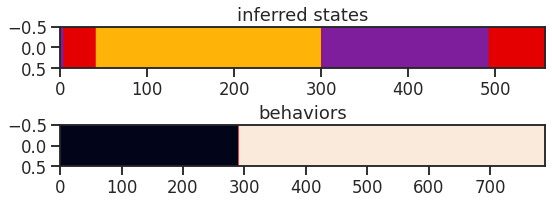

In [ ]:
for i in range(3):
  inferred_states = test['model'].most_likely_states(factors[i])
  f, axarr = plt.subplots(2,1, figsize = (8,3))
  f.tight_layout()
  axarr[0].imshow(inferred_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[0].set_title('inferred states')
  axarr[1].imshow([[1]*cue_on_bin[i] + [2] * (move_bin[i]-cue_on_bin[i]) + [3]*(len(inferred_states) - move_bin[i])] , aspect="auto")#, cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[1].set_title('behaviors')
  plt.show()